In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import tensorflow as tf
tf.__version__

'2.0.0'

In [94]:
import warnings
warnings.filterwarnings("ignore")

import os
import tensorflow as tf
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import euclidean 
from insightface.embedder import InsightfaceEmbedder
import pandas as pd
from glob import glob
from tqdm import tqdm
from time import time
import IPython


In [88]:
model_path = "models/model-r34-amf/model"
embedder = InsightfaceEmbedder(model_path=model_path, epoch_num='0000', image_size=(112, 112),
                               no_face_raise=False,
                               MTCNN_min_face_size=50, MTCNN_steps_threshold=[0.7, 0.7, 0.9])

loading models/model-r34-amf/model 0


In [89]:
tf.__version__

'2.0.0'

In [90]:
dfPeople = pd.DataFrame()
dfPeople['name'] = 'object'
dfPeople['path'] = 'object'
dfPeople['embedding'] = 'object'
dfPeople['bbox'] = 'object'

faceDetection_imgHeight = 256

path = 'data/People/'

def get_embeddings(path):
    people_list = os.listdir(path)
    
    count = 0
    print(f'Обнаружено {len(people_list)} индивидов')
    print(f'Создание базы эмбеддингов')
    
    for man in tqdm(people_list):
        photos = os.listdir(f'data/People/{man}')
        for photo in photos:
            img_path = f'data/People/{man}/{photo}'
            img = cv2.imread(img_path)
            emb_img, bboxes_img, points = embedder.embed_image(img, faceDetection_imgHeight=faceDetection_imgHeight)
            dfPeople.at[count, 'name'] = man
            dfPeople.at[count, 'path'] = img_path
            dfPeople.at[count, 'embedding'] = emb_img[0]
            dfPeople.at[count, 'bbox']      = bboxes_img[0]
            count += 1
    return dfPeople

dfPeople = get_embeddings(path)

  0%|          | 0/4 [00:00<?, ?it/s]

Обнаружено 4 индивидов
Создание базы эмбеддингов


100%|██████████| 4/4 [00:00<00:00,  5.29it/s]


In [91]:
def show_baza(dfPeople):
    for i in dfPeople.index:
        path = dfPeople.at[i, 'path']
        img = plt.imread(path)
        startPoint = dfPeople.at[i, 'bbox'][:2]
        endPoint = dfPeople.at[i, 'bbox'][2:4]
        cv2.rectangle(img, tuple(startPoint), tuple(endPoint), (0,255,0), 4)
        plt.imshow(img)
        plt.show()
        
### Averagin embedding
def average_embeddings(dfPeople):
    df = pd.DataFrame()
    df['name'] = 'name'
    df['embedding'] = 'embedding'

    for ind, name in enumerate(dfPeople['name'].value_counts().index):
        person = dfPeople[dfPeople['name'] == name]
        df.at[ind, 'name'] = name
        df.at[ind, 'embedding'] = np.average(person['embedding'].values, axis=0)
    return df

def process_frame(bgr_frame, faceDetection_imgHeight, threshold):
    # Find all the faces and face encodings in the current frame of video
    face_encodings, face_locations, face_points = embedder.embed_image(bgr_frame, faceDetection_imgHeight=faceDetection_imgHeight)
    if face_encodings != None:
        face_names = []
        dists_list = []
        for face_encoding in face_encodings:
            # See if the face is a match for the known face(s)
            distances = np.linalg.norm(dfPeople['embedding'].values.tolist() - face_encoding, axis=1)
            matches = distances <= threshold
            min_dist = min(distances)
            dists_list.append(min_dist)
            name = 'Unknown'
            if matches.sum() > 0:
                name = dfPeople['name'][matches].value_counts().index[0]
            face_names.append(name)

        # Label the results
        ind = 0
        for (left, top, right, bottom), name in zip(face_locations, face_names):
            # Draw a box around the face
            # Draw a label with a name below the face
            cv2.rectangle(bgr_frame, (left, top), (right, bottom), (0, 255, 0), 4)
            font = cv2.FONT_HERSHEY_DUPLEX
            cv2.putText(bgr_frame, f"{name}, {str(dists_list[ind])[:4]}", (left, bottom), font, 0.7, 
                        (0, 255, 0), 1)
            ind += 1

    return bgr_frame, face_names

#Mobilenet - 21.42 length of the descriptor - 128 -
#Resnet34 - 41 length of the descriptor - 512 - 
#Resnet100 - 81 length of the descriptor - 512 - 
# show_baza(dfPeople)
def save_logs(df):
    df.to_csv(f'logs/tables/{str(DT_saved)[:13]}.csv')
    
def save_frame(frame):
    cv2.imwrite(f'logs/images/{str(DT_saved)[:19]}.jpg', frame)

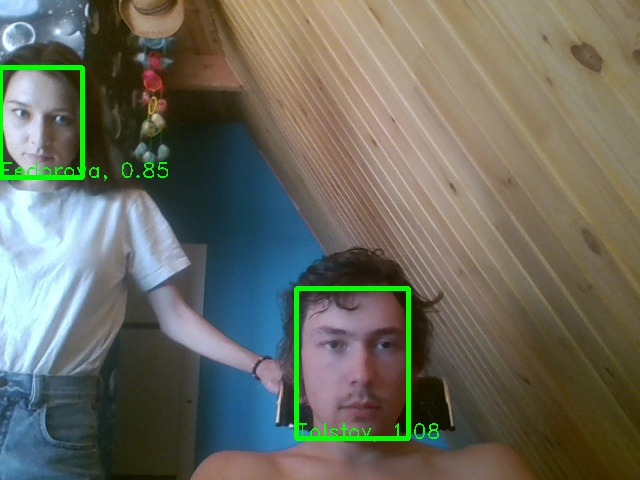

In [109]:
%matplotlib inline

logging = True
faceDetection_imgHeight=256
video_capture = cv2.VideoCapture(0)

ret, frame = video_capture.read()
frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGBA)

if logging == True:
    #Initialize DataFrame
    logDf = pd.DataFrame(columns=['time', 'num_faces', 'face_names'])
    DT_saved = datetime.fromtimestamp(time())
    logDf['time'] = pd.to_datetime(logDf['time'])
    logDf['face_names'] = logDf['face_names'].astype('object')
    recentNamesList = []
    logIndex = 0


    fig = plt.figure()
    ax1 = fig.add_subplot(1,1,1)

    def animate(i):
        ax1.clear()
        ax1.plot(logDf['time'],logDf['num_faces'])

    plt.show()
    ani = animation.FuncAnimation(fig, animate, interval=1000)

try:
    while True:
        ret, bgr_frame = video_capture.read()
        frame, face_names = process_frame(bgr_frame, faceDetection_imgHeight, threshold=1.1)
        _, frame = cv2.imencode('.jpg', frame) 
        
        if logging == True:
            for name in face_names:
                if name not in recentNamesList:
                    recentNamesList.append(name)
                    frameSave = True
                else:
                    frameSave = False

                        
            if face_names != None:    
                # Renew logs
                DT_row = datetime.fromtimestamp(time())
                new_row = [DT_row, len(face_names), face_names]
                logDf.loc[logIndex] = new_row; logIndex += 1  

                # Save logs
                if (DT_row - DT_saved).seconds > 10 or (DT_row - DT_saved).days == 1: 
                    print('*** Logs saved')
                    DT_saved = datetime.fromtimestamp(time())
                    save_logs(logDf)
                    recentNamesList = []

                        # Save frame
                if frameSave == True:
                    print('*** Frame saved')
                    save_frame(bgr_frame)
            
                    
        i = IPython.display.Image(data=frame)
        IPython.display.display(i)
        IPython.display.clear_output(wait=True)
        
except KeyboardInterrupt:
    video_capture.release()    